# <font color='brown'> CNN - Melanoma Detection Assignment</font>

**`Problem statement:`** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [1]:
# mounting google drive to import dataset (data kept on drive and using colab to utilize GPUs for faster results)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing all the important libraries

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images (updating paths from drive)
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Test')

In [4]:
# Checking counts for train and test sets now
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images in Train Subset : ",image_count_train)

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images in Test Subset : ",image_count_test)

print("Validating above statement for total images : ", (image_count_train + image_count_test))

Images in Train Subset :  2239
Images in Test Subset :  118
Validating above statement for total images :  2357


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [5]:
#Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# train dataset (80% of all images)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               seed=123,
                                                               subset='training',validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# validation dataset (20% of all images)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             batch_size=batch_size,
                                                             image_size=(img_width,img_height),
                                                             seed=123,
                                                             subset='validation',validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# listing out all class names 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

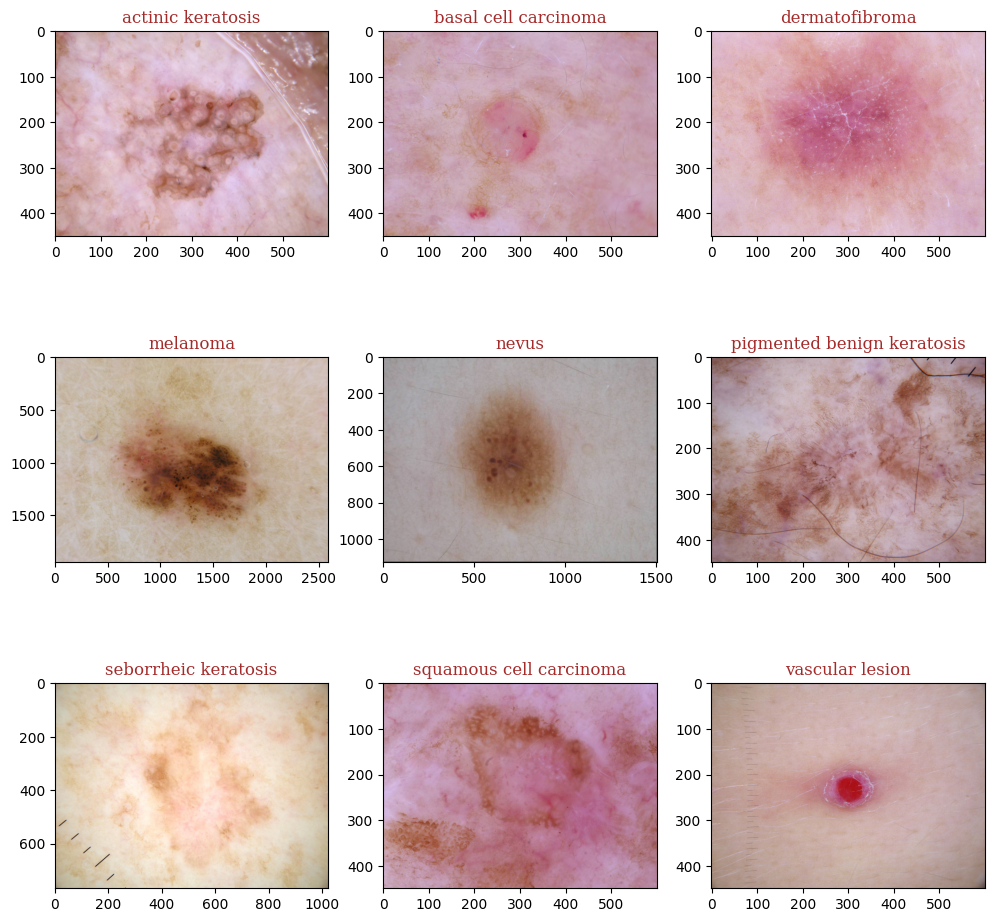

In [9]:
# visualizing one image from all folders in training set

plt.figure(figsize=(12,12))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  img = plt.imread(str(list(data_dir_train.glob(class_names[i] + '/*.jpg'))[0]))
  plt.title(class_names[i],fontdict={'family': 'serif', 'color':  'brown', 'weight':'normal','size': 12})
  plt.imshow(img)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. 
- Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### <font color='brown'> Model 1 </font>

**`Brief architecture`**

- three `convolution layers` with 16, 32, & 64 filters respectively
- each convolution layer followed by a MaxPooling layer
- flatten layer to convert data in vector format
- dense layer with 64 neurons
- dense softmax layer to categorize into 9 classes

In [11]:
# model 1 without dropout
nn_model = Sequential()

#normalizing pixel values between (0,1)
nn_model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# 1st convolution layer
nn_model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model.add(MaxPool2D(pool_size=(2,2)))

#2nd convolution layer
nn_model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model.add(MaxPool2D(pool_size=(2,2)))

#3rd convolution layer
nn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model.add(MaxPool2D(pool_size=(2,2)))

# flatten and put a fully connected layer
nn_model.add(Flatten())
nn_model.add(Dense(64,activation='relu'))

#softmax layer
nn_model.add(Dense(len(class_names), activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
#Adam: method for efficient stochastic optimization that only requires first-order gradients with little memory requirements
#categorical_crossentropy: It's a loss function for multi-class classification model (truth labels are integer encoded, for example, [1], [2] and [3] for 3-class problem.)

nn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# viewing summary for model 1
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = nn_model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 748s 3s/step - loss: 2.0632 - accuracy: 0.2394 - val_loss: 1.8513 - val_accuracy: 0.3870
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6384 - accuracy: 0.4487 - val_loss: 1.4807 - val_accuracy: 0.5034
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4207 - accuracy: 0.5095 - val_loss: 1.4029 - val_accuracy: 0.5481
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3076 - accuracy: 0.5424 - val_loss: 1.3996 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2916 - accuracy: 0.5541 - val_loss: 1.4587 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1648 - accuracy: 0.5854 - val_loss: 1.4601 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1012 - accuracy: 0.6222 - val_loss: 1.4156 - val_accuracy: 0.5302
Epoch 8/20
56/56 [======

### Visualizing training results

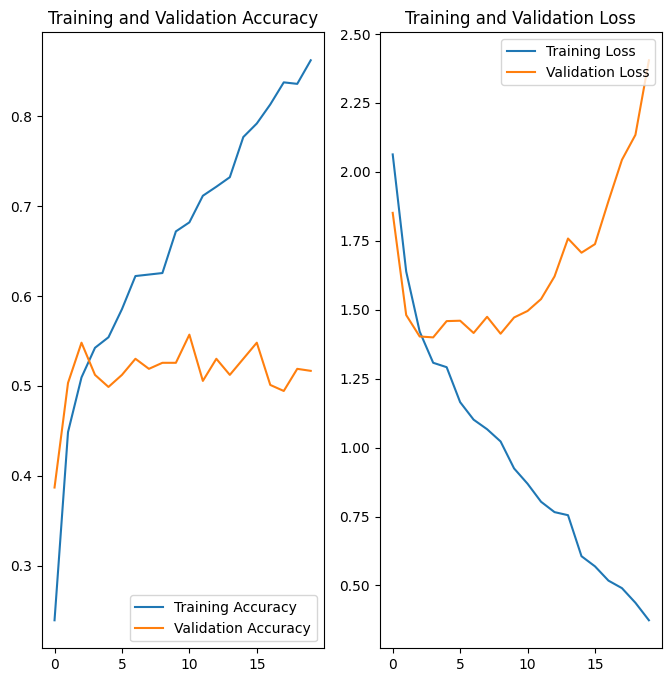

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### <font color='blue'>Findings from the model</font>

- we see that training accuracy is increasing and training loss is decreasing with subsequent increase in epoch
- for validation subset, the accuracy slightly throughout the execution for all epochs and the loss initially dips a bit but then increases gradually
- overall, we can say that model is performing well on training subset (high accuracy and low loss) & performs poorly on validation subset (low accuracy and high loss)
- thus, we can conclude model tends to be overfitting

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentor = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.1),
                             layers.experimental.preprocessing.RandomZoom(0.1)])

# randomly flips images horizontal (left-right flip) mode, randomly rotating and zooming images

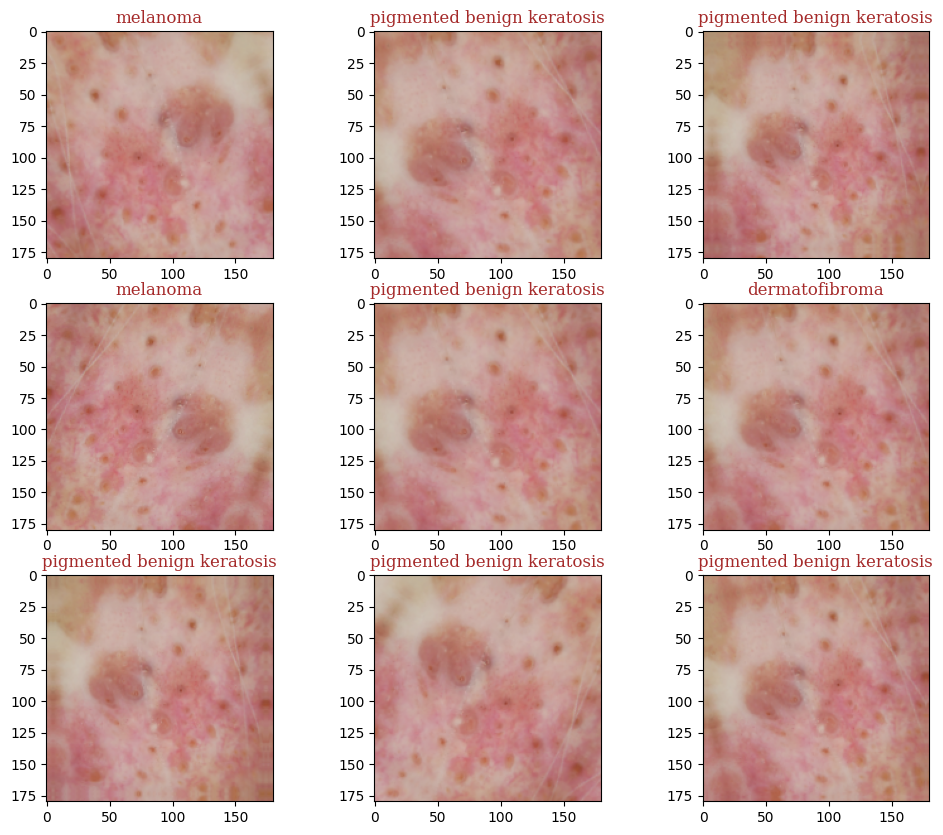

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12,10))
for images, label in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentor(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]],fontdict={'family': 'serif', 'color':  'brown', 'weight':'normal','size': 12})

### Todo:
### Create the model, compile and train the model


### <font color='brown'> Model 2 : Dropout and augmentation layers </font>

**`Brief architecture`**

- rescaling pixel values between [0,1] as RGB channel values in range [0, 255] are not considered ideal for a neural network.
- introducing augmentation layer where we introduce random rotations, flips and zooms
- three convolution layers with 16,32 & 64 filters respectively
- each convolution layer followed by a MaxPooling layer
- all 3 convolution layers followed by dropout to have 25% reduction in inputs carried forward
- flatten layer to convert data in vector format
- dense layer with 64 neurons
- dropout layer to reduce 50%
- dense softmax layer to categorize into 9 classes

In [18]:
#model2 post post applying augmentation strategy and using dropout layers this time

nn_model2 = Sequential()

#normalizing pixel values between (0,1)
nn_model2.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

#augmentation layer before first convolution layer
nn_model2.add(data_augmentor)

# 1st convolution layer with 25% inputs to drop through dropout layer
nn_model2.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model2.add(MaxPool2D(pool_size=(2,2)))
nn_model2.add(Dropout(0.25))

# 2nd convolution layer with 25% inputs to drop through dropout layer
nn_model2.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model2.add(MaxPool2D(pool_size=(2,2)))
nn_model2.add(Dropout(0.25))

# 3rd convolution layer with 25% inputs to drop through dropout layer
nn_model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model2.add(MaxPool2D(pool_size=(2,2)))
nn_model2.add(Dropout(0.25))


# flatten and fully connected layer followed by another input dropout by 50% this time
nn_model2.add(Flatten())
nn_model2.add(Dense(64,activation='relu'))
nn_model2.add(Dropout(0.50))

# softmax layer
nn_model2.add(Dense(len(class_names), activation = "softmax"))


### Compiling the model

In [19]:
# compiling step
nn_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# looking at summary for model 2
nn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [21]:
epochs = 20   #training for 20 epochs
history = nn_model2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )

Epoch 1/20
56/56 [==============================] - 5s 33ms/step - loss: 2.2935 - accuracy: 0.1920 - val_loss: 2.1254 - val_accuracy: 0.2036
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 2.0789 - accuracy: 0.2070 - val_loss: 2.0311 - val_accuracy: 0.2908
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 2.0122 - accuracy: 0.2427 - val_loss: 1.9996 - val_accuracy: 0.3177
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.9688 - accuracy: 0.2556 - val_loss: 1.9243 - val_accuracy: 0.3579
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.9215 - accuracy: 0.2818 - val_loss: 1.9718 - val_accuracy: 0.2908
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.8682 - accuracy: 0.3142 - val_loss: 1.8402 - val_accuracy: 0.4004
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.8479 - accuracy: 0.3259 - val_loss: 1.8420 - val_accuracy: 0.3848
Epoch 8/20
56

### Visualizing the results

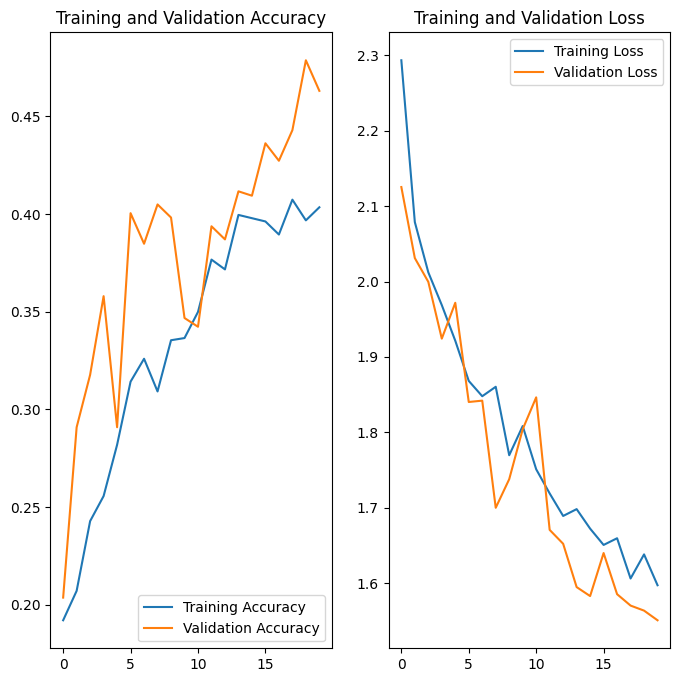

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### <font color='brown'> Findings from Model2</font>

`comparison w.r.t. Model1`

- validation accuracy has improved, and thus, reducing gap between both
- similar observation can be made from loss perspective as validation loss has shown improvements to great extents
- overall accuracy has fallen for training subset as now both training and validation accuracy score below 50%
- from all above points, we can comment that overfitting has reduced


#### **Todo:** Find the distribution of classes in the training dataset.

### <font color='brown'> Checking for Class Imbalance
    
#### **Context:**
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
#looking at original counrs again
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images in Train Subset : ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images in Test Subset : ",image_count_test)

Images in Train Subset :  2239
Images in Test Subset :  118


In [24]:
category=[]
num_samples=[]
for i in range(len(class_names)):
  category.append(class_names[i])
  num_samples.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

#list(zip(category,num_samples))


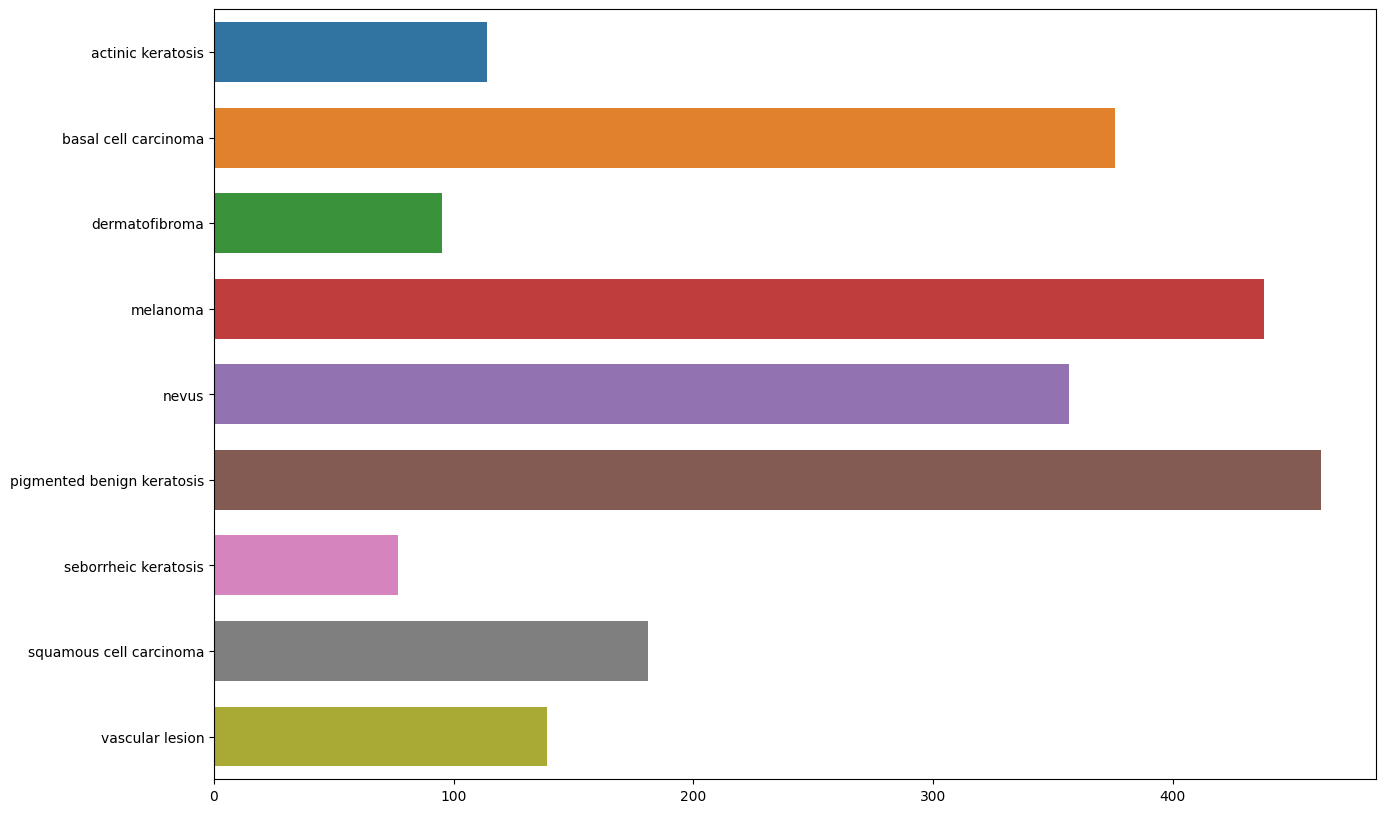

In [25]:
plt.figure(figsize=(15,10))
sns.barplot(y=category,x=num_samples,width=0.7)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


In [26]:
pd.DataFrame(list(zip(category,num_samples)),columns=['Class','Number of Images']).sort_values(by='Number of Images',ascending=True)

,Class,Number of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

#### findings for todo task above
1. Which class has the least number of samples?
  - **seborrheic keratosis** has least number of samples

2. Which classes dominate the data in terms proportionate number of samples?
  - **pigmented benign keratosis** is dominant with max number of sample images



In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset='/content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6185580F70>: 100%|██████████| 500/500 [00:24<00:00, 20.76 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61855B8F40>: 100%|██████████| 500/500 [00:26<00:00, 19.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61855EAD90>: 100%|██████████| 500/500 [00:24<00:00, 20.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F620659FD90>: 100%|██████████| 500/500 [01:45<00:00,  4.75 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F6185555C70>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6201FF16D0>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6201B1EAC0>: 100%|██████████| 500/500 [00:49<00:00, 10.19 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6201E4D550>: 100%|██████████| 500/500 [00:20<00:00, 24.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6201B01250>: 100%|██████████| 500/500 [00:22<00:00, 21.78 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
actinic keratosis             500
nevus                         500
seborrheic keratosis          500
squamous cell carcinoma       500
dermatofibroma                500
vascular lesion               500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
#path_to_training_dataset='/content/gdrive/MyDrive/UpGrad Neural Network/ISIC Melanoma/Train/'
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split = 0.2,
                                                             subset = 'validation',
                                                             image_size=(img_height, img_width),
                                                             batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

### <font color='brown'> Model 3 : Implementing Batch Normalization along with Dropouts and Augmented Data </font>

**`Brief architecture`**

- rescaling pixel values between [0,1] as RGB channel values in range [0, 255] are not considered ideal for a neural network.
- three convolution layers with 16,32 & 64 filters respectively
- batch normalization transformation with all conlolution layers
- each convolution layer followed by a MaxPooling layer
- all 3 convolution layers followed by dropout to have 25% reduction in inputs carried forward
- flatten layer to convert data in vector format
- dense layer with 64 neurons
- dropout layer to reduce 50%
- dense softmax layer to categorize into 9 classes

In [38]:
# final model with dropouts augmented data and applying batch normalization too
# Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

nn_model3 = Sequential()

#normalizing pixel values between (0,1)
nn_model3.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# 1st convolution layer with 25% inputs to drop through dropout layer, added Batch Normalization this time
nn_model3.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model3.add(BatchNormalization())
nn_model3.add(MaxPool2D(pool_size=(2,2)))
nn_model3.add(Dropout(0.25))

# 2nd convolution layer with 25% inputs to drop through dropout layer
nn_model3.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model3.add(BatchNormalization())
nn_model3.add(MaxPool2D(pool_size=(2,2)))
nn_model3.add(Dropout(0.25))

# 3rd convolution layer with 25% inputs to drop through dropout layer
nn_model3.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
nn_model3.add(BatchNormalization())
nn_model3.add(MaxPool2D(pool_size=(2,2)))
nn_model3.add(Dropout(0.25))


# flatten and fully connected layer followed by another input dropout by 50% this time
nn_model3.add(Flatten())
nn_model3.add(Dense(64,activation='relu'))
nn_model3.add(Dropout(0.50))

# softmax layer
nn_model3.add(Dense(len(class_names), activation = "softmax"))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
# compiling step
nn_model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
# model summary
nn_model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [41]:
epochs = 30   # as asked, training for 30 iterations
history = nn_model3.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                   )

Epoch 1/30


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 57s 317ms/step - loss: 2.4967 - accuracy: 0.1341 - val_loss: 29.7579 - val_accuracy: 0.0898
Epoch 2/30
169/169 [==============================] - 39s 224ms/step - loss: 2.1852 - accuracy: 0.1397 - val_loss: 23.6476 - val_accuracy: 0.1024
Epoch 3/30
169/169 [==============================] - 39s 225ms/step - loss: 2.1824 - accuracy: 0.1432 - val_loss: 11.6815 - val_accuracy: 0.1017
Epoch 4/30
169/169 [==============================] - 36s 205ms/step - loss: 2.1784 - accuracy: 0.1434 - val_loss: 5.1408 - val_accuracy: 0.1425
Epoch 5/30
169/169 [==============================] - 35s 204ms/step - loss: 2.1772 - accuracy: 0.1434 - val_loss: 3.5659 - val_accuracy: 0.1455
Epoch 6/30
169/169 [==============================] - 39s 223ms/step - loss: 2.1765 - accuracy: 0.1434 - val_loss: 3.3108 - val_accuracy: 0.1507
Epoch 7/30
169/169 [==============================] - 34s 194ms/step - loss: 2.1762 - accuracy: 0.1434 - val_loss: 3.2751 - val_accuracy: 

#### **Todo:**  Visualize the model results

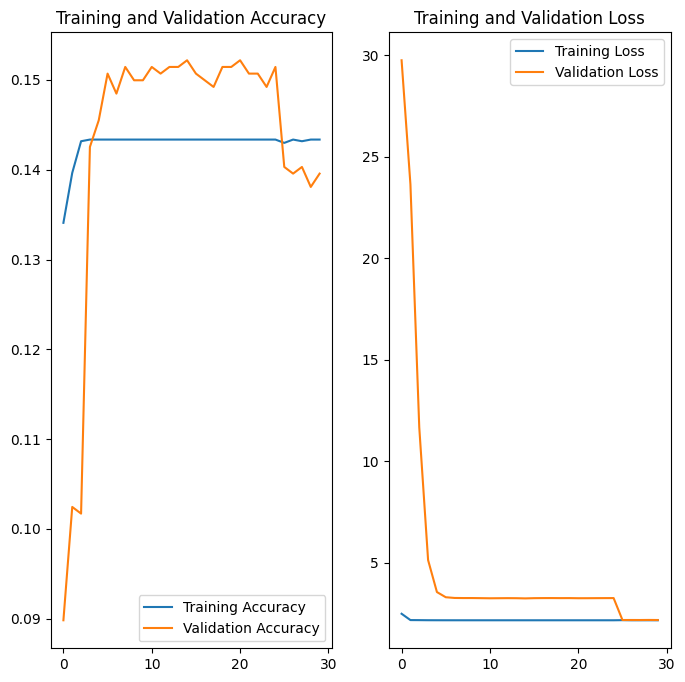

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

